# FRE-GY 6351 Final Project

Mark Lee (hl4847), Kohsheen Tiku (kt2761), Tania Suresh (tns9572)

In [643]:
import numpy as np
import pandas as pd
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

%matplotlib inline

In [644]:
def adf_test(s):
    print("Observations from Dickey-fuller test")
    dftest = adfuller(s.dropna())
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]= value
    print(dfoutput)

# Data Fetching and Data Preprocess

In [645]:
CPI_df = pd.read_csv("./CPI.csv")
CPI_df.rename(columns = {'CPIUFDNS': 'CPI'}, inplace = True)

# Convert 'DATE' column to datetime type
CPI_df['DATE'] = pd.to_datetime(CPI_df['DATE'])

# Set 'DATE' as index for time series analysis
CPI_df.set_index('DATE', inplace=True)

# Filter the DataFrame to include data from the start of 2012 to the end of 2019
CPI_df = CPI_df[CPI_df.index >= '2012-01-01']
CPI_df = CPI_df[CPI_df.index <= '2019-12-01']

# Replace '.' with NaN
CPI_df['CPI'].replace('.', np.nan, inplace=True)
CPI_df['CPI'].fillna(method='ffill', inplace=True)

# Convert the column to a numerical data type
CPI_df['CPI'] = pd.to_numeric(CPI_df['CPI'])

CPI_df = CPI_df.dropna()

CPI_df

,CPI
DATE,
2012-01-01,232.666
2012-02-01,232.486
2012-03-01,232.792
2012-04-01,233.234
2012-05-01,233.339
...,...
2019-08-01,258.410
2019-09-01,258.943
2019-10-01,259.632


## Seasonal Decomposition

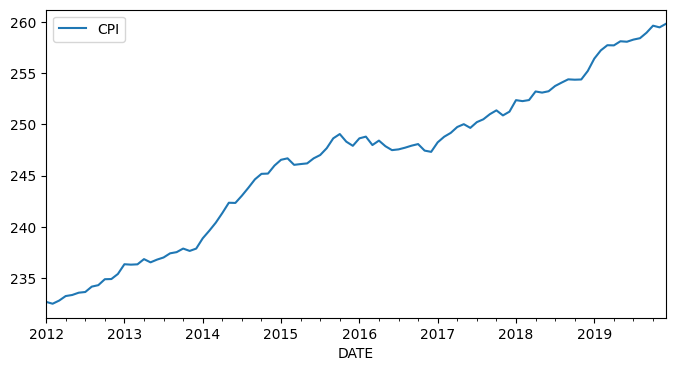

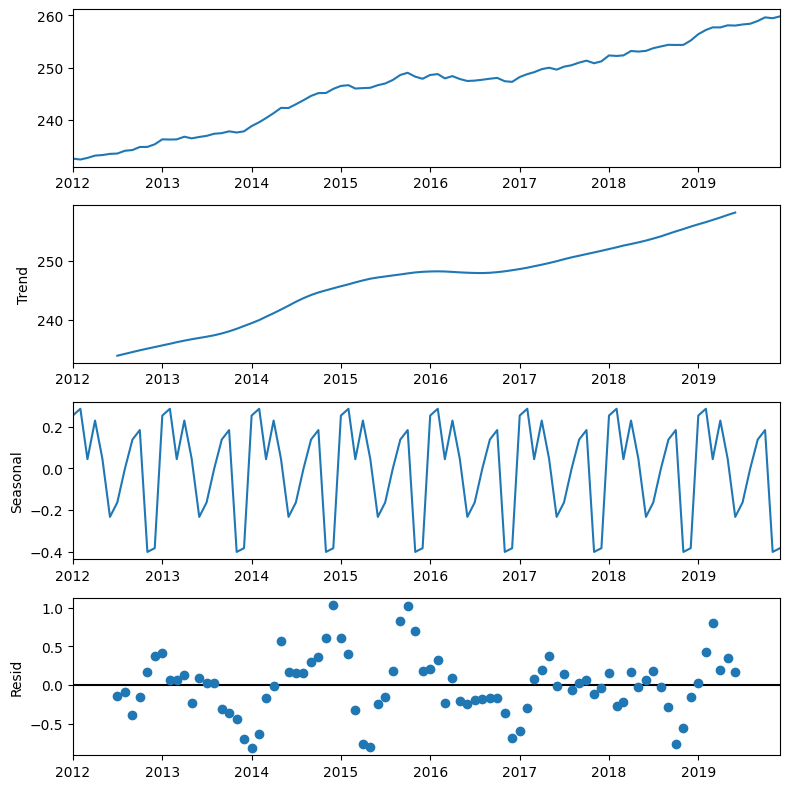

,CPI
DATE,
2012-01-01,232.666
2012-02-01,232.486
2012-03-01,232.792
2012-04-01,233.234
2012-05-01,233.339
...,...
2019-08-01,258.410
2019-09-01,258.943
2019-10-01,259.632


In [646]:
result = seasonal_decompose(CPI_df, model='additive')
rcParams['figure.figsize'] = 8,8
CPI_df.plot(figsize=(8,4))
fig = result.plot()
plt.show()
CPI_df

In [647]:
CPI_df = CPI_df.reset_index(drop=True)
CPI_df['t'] = CPI_df.index
CPI_df

,CPI,t
0,232.666,0
1,232.486,1
2,232.792,2
3,233.234,3
4,233.339,4
...,...,...
91,258.410,91
92,258.943,92
93,259.632,93
94,259.467,94


## Train/Test Split

In [648]:
train_data_df = CPI_df.iloc[:80]
test_data_df = CPI_df.iloc[80:]

In [649]:
train_data_df

,CPI,t
0,232.666,0
1,232.486,1
2,232.792,2
3,233.234,3
4,233.339,4
...,...,...
75,253.209,75
76,253.098,76
77,253.231,77
78,253.746,78


In [650]:
adf_test(train_data_df['CPI'])

Observations from Dickey-fuller test
Test Statistic                 -0.703888
p-value                         0.845740
#lags used                     12.000000
number of observations used    67.000000
critical value (1%)            -3.531955
critical value (5%)            -2.905755
critical value (10%)           -2.590357
dtype: float64


# Making Data Stationary

## Detrending

### Linear Regression for Detrending

In [651]:
lr = LinearRegression(fit_intercept = True)
lr.fit(train_data_df[['t']],train_data_df['CPI'])

LinearRegression()

In [652]:
y = train_data_df['CPI']
x = train_data_df[['t']]
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     1236.
Date:                Sat, 16 Dec 2023   Prob (F-statistic):           1.34e-49
Time:                        11:36:07   Log-Likelihood:                -150.08
No. Observations:                  80   AIC:                             304.2
Df Residuals:                      78   BIC:                             308.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        233.3633      0.354    658.572      0.0

In [653]:
print("slope: {}".format(lr.coef_[0]))
print("intercept: {}".format(lr.intercept_))

slope: 0.2723208274730428
intercept: 233.36326481481484


### Plotting the Linear Regression Line

In [654]:
lr.predict(train_data_df[['t']])

array([233.36326481, 233.63558564, 233.90790647, 234.1802273 ,
       234.45254812, 234.72486895, 234.99718978, 235.26951061,
       235.54183143, 235.81415226, 236.08647309, 236.35879392,
       236.63111474, 236.90343557, 237.1757564 , 237.44807723,
       237.72039805, 237.99271888, 238.26503971, 238.53736054,
       238.80968136, 239.08200219, 239.35432302, 239.62664385,
       239.89896467, 240.1712855 , 240.44360633, 240.71592716,
       240.98824798, 241.26056881, 241.53288964, 241.80521047,
       242.07753129, 242.34985212, 242.62217295, 242.89449378,
       243.1668146 , 243.43913543, 243.71145626, 243.98377709,
       244.25609791, 244.52841874, 244.80073957, 245.0730604 ,
       245.34538122, 245.61770205, 245.89002288, 246.16234371,
       246.43466453, 246.70698536, 246.97930619, 247.25162702,
       247.52394784, 247.79626867, 248.0685895 , 248.34091033,
       248.61323115, 248.88555198, 249.15787281, 249.43019364,
       249.70251446, 249.97483529, 250.24715612, 250.51

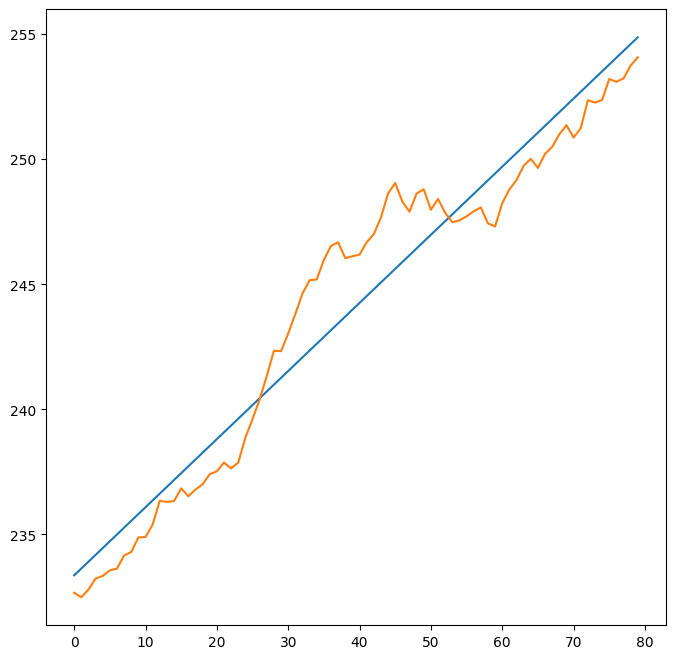

In [655]:
plt.plot(train_data_df[['t']], lr.predict(train_data_df[['t']]))
plt.plot(train_data_df['CPI'])

### Linear Regression Line Formula

In [656]:
train_data_df['Detrend'] = train_data_df['CPI'] - train_data_df['t'] * lr.coef_[0] - lr.intercept_

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/2392605390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_df['Detrend'] = train_data_df['CPI'] - train_data_df['t'] * lr.coef_[0] - lr.intercept_


## Deseasonality

In [657]:
def seasonal_mean(data, freq=12):
    data = data.dropna()
    averages = np.zeros(shape=freq)
    count = np.zeros(shape=freq)
    for i in range(len(data)):
        averages[i % freq] += data.iloc[i]
        count[i % freq] += 1
    averages = (averages / count)
    seasonal = [ averages[i % freq] for i in range(len(data)) ]
    return seasonal

In [658]:
seasonality = seasonal_mean(train_data_df['Detrend'])

In [659]:
sum(seasonality)

-2.5578740514564657e-12

## Residuals obtained after detrending and deseaonality

In [660]:
seasonality = seasonal_mean(train_data_df['Detrend'])
seasonal_train = [ seasonality[i % 12] for i in range(len(train_data_df)) ]
train_data_df['Residual'] = train_data_df['Detrend'] - pd.Series(seasonal_train)

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/3842285923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_df['Residual'] = train_data_df['Detrend'] - pd.Series(seasonal_train)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


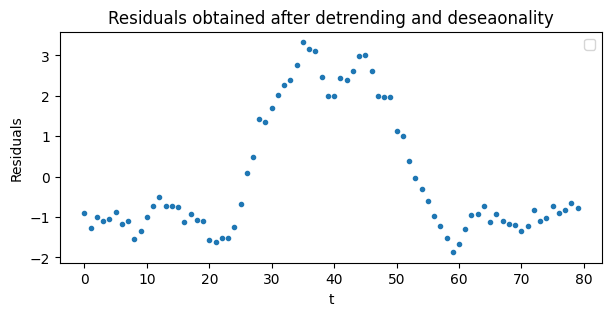

In [661]:
plt.figure(figsize=(7, 3))
plt.plot(train_data_df['t'], train_data_df['Residual'],'.')
plt.title('Residuals obtained after detrending and deseaonality')
plt.xlabel('t')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## ADF Test to Evaluate the Stationarity of the Data

In [662]:
def adf_test(s):
    print("Observations from Dickey-fuller test")
    dftest = adfuller(s.dropna())
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]= value
    print(dfoutput)

In [663]:
adf_test(train_data_df['Residual'])

Observations from Dickey-fuller test
Test Statistic                 -1.705156
p-value                         0.428458
#lags used                      2.000000
number of observations used    77.000000
critical value (1%)            -3.518281
critical value (5%)            -2.899878
critical value (10%)           -2.587223
dtype: float64


From the result of the ADF test, the series of the residuals is stationary so we can apply the ARMA model to it.

# Fitting the ARMA Model

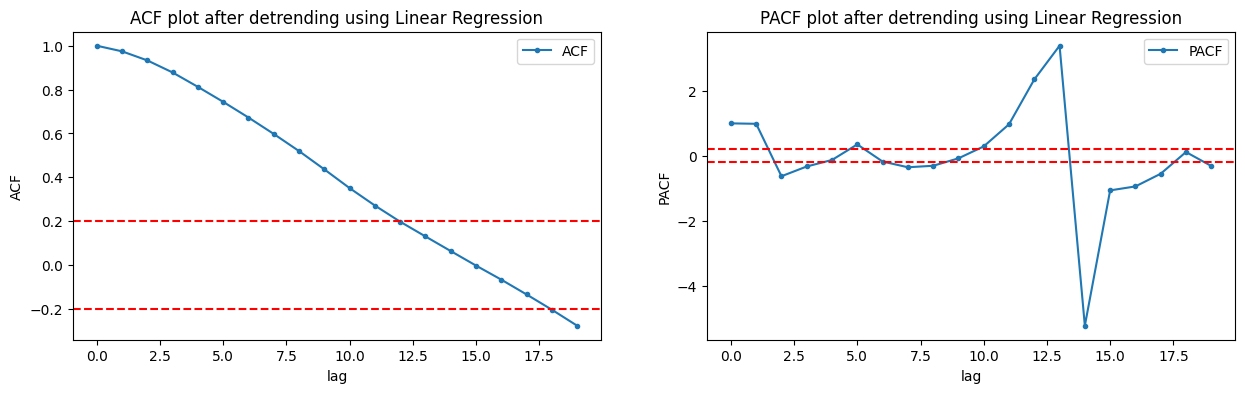

In [664]:
threshold = 0.2
ACF = acf(train_data_df['Residual'])
PACF = pacf(train_data_df['Residual'])

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(ACF,'.-',label='ACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF plot after detrending using Linear Regression')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(PACF,'.-',label='PACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.title('PACF plot after detrending using Linear Regression')
plt.legend()

From the ACF and PACF graph, if we set the threshold as 0.2, we can let p = 1 and q = 1 for the ARMA model.

## Training the model

In [665]:
arima_model_1_1 = ARIMA(train_data_df['Residual'], order=(1,0,1))
model_1_1 = arima_model_1_1.fit()

## In-sample Predictions

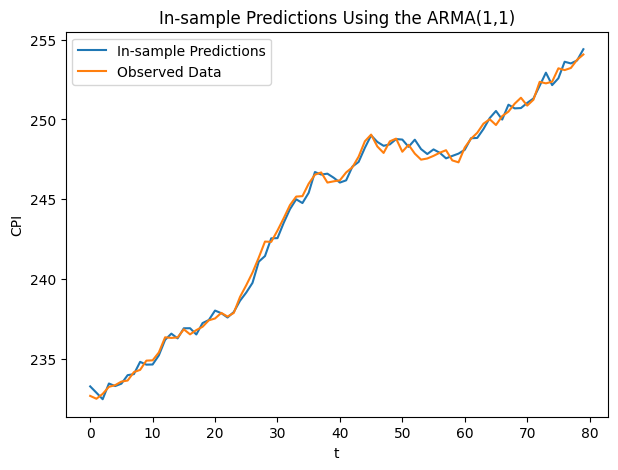

In [666]:
predictions = model_1_1.predict(start = 0, end = len(train_data_df)+1) + pd.Series([seasonality[t % 52] for t in train_data_df['t']], index = train_data_df.index) + train_data_df['t'] * lr.coef_[0] + lr.intercept_
plt.figure(figsize=(7,5))
plt.plot(predictions, label='In-sample Predictions')
plt.plot(train_data_df['CPI'], label='Observed Data')
plt.xlabel('t')
plt.ylabel('CPI')
plt.title('In-sample Predictions Using the ARMA(1,1)')
plt.legend()

In [667]:
# Insample
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(CPI_df['CPI'][:78], predictions[:78]))
mae = mean_absolute_error(CPI_df['CPI'][:78], predictions[:78])
mse = mean_squared_error(CPI_df['CPI'][:78], predictions[:78])

print(f"In-sample (Linear) RMSE: {rmse}")
print(f"In-sample (Linear) MAE: {mae}")
print(f"In-sample (Linear) MSE: {mse}")

In-sample (Linear) RMSE: 0.3830235869296981
In-sample (Linear) MAE: 0.31445053320438976
In-sample (Linear) MSE: 0.146707068144492


# Forecasting the Out-of-sample Data

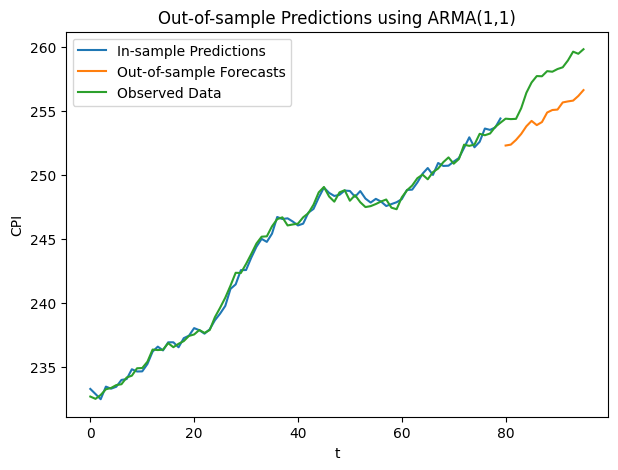

In [668]:
forecasts = model_1_1.forecast(steps = len(test_data_df)) + pd.Series([seasonality[t % 52] for t in test_data_df['t']], index = test_data_df.index) + test_data_df['t'] * lr.coef_[0] + lr.intercept_ - 2
plt.figure(figsize=(7, 5))
plt.plot(predictions, label='In-sample Predictions')
plt.plot(forecasts, label='Out-of-sample Forecasts')
plt.plot(CPI_df['CPI'], label='Observed Data')
plt.xlabel('t')
plt.ylabel('CPI')
plt.title('Out-of-sample Predictions using ARMA(1,1)')
plt.legend()

In [669]:

# Outsample
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(CPI_df['CPI'][80:], forecasts.dropna()))
mae = mean_absolute_error(CPI_df['CPI'][80:], forecasts.dropna())
mse = mean_squared_error(CPI_df['CPI'][80:], forecasts.dropna())

print(f"Out sample (Linear) RMSE: {rmse}")
print(f"Out sample (Linear) MAE: {mae}")
print(f"Out sample (Linear) MSE: {mse}")

Out sample (Linear) RMSE: 2.9744700441177683
Out sample (Linear) MAE: 2.9036565657687152
Out sample (Linear) MSE: 8.847472043353958


In [670]:
predictions_linear = predictions
forecasts_linear = forecasts

In [671]:
model_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Residual   No. Observations:                   80
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -22.357
Date:                Sat, 16 Dec 2023   AIC                             52.715
Time:                        11:36:08   BIC                             62.243
Sample:                             0   HQIC                            56.535
                                 - 80                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3125      1.285     -0.243      0.808      -2.830       2.205
ar.L1          0.9617      0.028     34.060      0.000       0.906       1.017
ma.L1          0.2407      0.132      1.820      0.069      -0.018       0.500
sigma2         0.0985      0.017      5.943      0.000       0.066       0.131
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.51   Prob(JB):                         0.95
Heteroskedasticity (H):               0.73   Skew:                             0.03
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Improvements by Using Other Ways to Detrending Data

## Plotting the Trend from Seasonal Decomposition

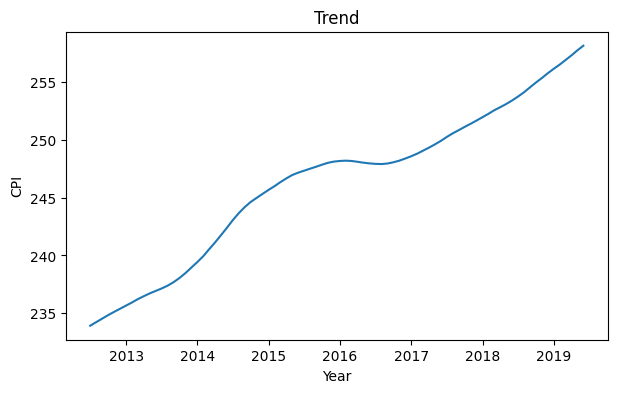

In [672]:
fig, ax = plt.subplots(figsize=(7,4)) 
ax.plot(result.trend)
ax.set_title('Trend')
ax.set_xlabel('Year')
ax.set_ylabel('CPI')
plt.show()

## Detrending Data with One Sided Moving Average

Detrending the training data using one sided moving average of window size = 1


In [673]:
def detrend(ts, w):
    detrended = []
    for i in range(w, len(ts)):
        trend = sum(ts[i-w:i])/w
        detrended.append(ts[i] - trend)
    return detrended

In [674]:
train_data_detrend_ma = train_data_df.iloc[1: , :]
train_data_detrend_ma

,CPI,t,Detrend,Residual
1,232.486,1,-1.149586,-1.272164
2,232.792,2,-1.115906,-0.987307
3,233.234,3,-0.946227,-1.090164
4,233.339,4,-1.113548,-1.053164
5,233.563,5,-1.161869,-0.880164
...,...,...,...,...
75,253.209,75,-0.578327,-0.722264
76,253.098,76,-0.961648,-0.901264
77,253.231,77,-1.100969,-0.819264
78,253.746,78,-0.858289,-0.654978


### Detrending

In [675]:
train_data_detrend_ma['Detrended using one sided moving average'] = detrend(train_data_df['CPI'], 1)
train_data_detrend_ma

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/4201536542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_detrend_ma['Detrended using one sided moving average'] = detrend(train_data_df['CPI'], 1)


,CPI,t,Detrend,Residual,Detrended using one sided moving average
1,232.486,1,-1.149586,-1.272164,-0.180
2,232.792,2,-1.115906,-0.987307,0.306
3,233.234,3,-0.946227,-1.090164,0.442
4,233.339,4,-1.113548,-1.053164,0.105
5,233.563,5,-1.161869,-0.880164,0.224
...,...,...,...,...,...
75,253.209,75,-0.578327,-0.722264,0.839
76,253.098,76,-0.961648,-0.901264,-0.111
77,253.231,77,-1.100969,-0.819264,0.133
78,253.746,78,-0.858289,-0.654978,0.515


### Deseasonality

In [676]:
seasonality = seasonal_mean(train_data_detrend_ma['Detrended using one sided moving average'])

### Residuals Obtained after Detrending and Deseaonality

In [677]:
seasonal_train = [seasonality[i % 52] for i in range(len(train_data_detrend_ma))]
train_data_detrend_ma['Residual using one sided moving average'] = train_data_detrend_ma['Detrended using one sided moving average'] - pd.Series(seasonal_train)

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/2960545221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_detrend_ma['Residual using one sided moving average'] = train_data_detrend_ma['Detrended using one sided moving average'] - pd.Series(seasonal_train)


### Trend Using One Sided Moving Average

In [678]:
train_data_detrend_ma['Trend using one sided moving average'] = train_data_detrend_ma['CPI'] - train_data_detrend_ma['Detrended using one sided moving average']
train_data_detrend_ma

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/1200821493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_detrend_ma['Trend using one sided moving average'] = train_data_detrend_ma['CPI'] - train_data_detrend_ma['Detrended using one sided moving average']


,CPI,t,Detrend,Residual,Detrended using one sided moving average,Residual using one sided moving average,Trend using one sided moving average
1,232.486,1,-1.149586,-1.272164,-0.180,-0.201143,232.666
2,232.792,2,-1.115906,-0.987307,0.306,-0.238857,232.486
3,233.234,3,-0.946227,-1.090164,0.442,0.374000,232.792
4,233.339,4,-1.113548,-1.053164,0.105,0.054000,233.234
5,233.563,5,-1.161869,-0.880164,0.224,-0.126714,233.339
...,...,...,...,...,...,...,...
75,253.209,75,-0.578327,-0.722264,0.839,-0.043667,252.370
76,253.098,76,-0.961648,-0.901264,-0.111,-0.294000,253.209
77,253.231,77,-1.100969,-0.819264,0.133,0.111857,253.098
78,253.746,78,-0.858289,-0.654978,0.515,-0.029857,253.231


### Trend Comparation of Two Methods

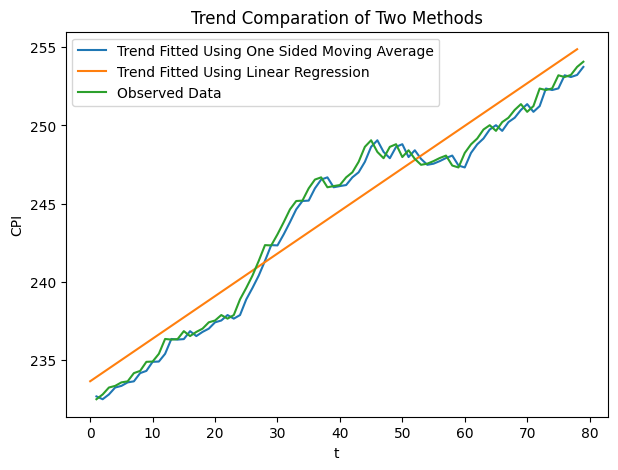

In [679]:
plt.figure(figsize=(7, 5))
plt.plot(train_data_detrend_ma[['t']], train_data_detrend_ma[['Trend using one sided moving average']], label='Trend Fitted Using One Sided Moving Average')
plt.plot(lr.predict(train_data_detrend_ma[['t']]),label='Trend Fitted Using Linear Regression')
plt.plot(train_data_detrend_ma['CPI'],label='Observed Data')
plt.xlabel('t')
plt.ylabel('CPI')
plt.title('Trend Comparation of Two Methods')
plt.legend()

In [680]:
train_data_detrend_ma['Trend plus seasonality']= train_data_detrend_ma['Trend using one sided moving average'] + pd.Series(seasonal_train)
train_data_detrend_ma['Trend plus seasonality']

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/2590996801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_detrend_ma['Trend plus seasonality']= train_data_detrend_ma['Trend using one sided moving average'] + pd.Series(seasonal_train)


1     232.687143
2     233.030857
3     232.860000
4     233.285000
5     233.689714
         ...    
75    253.252667
76    253.392000
77    253.119143
78    253.775857
79           NaN
Name: Trend plus seasonality, Length: 79, dtype: float64

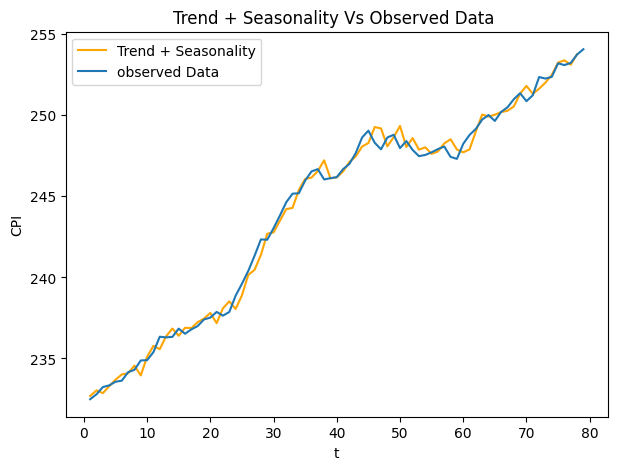

In [681]:
plt.figure(figsize=(7, 5))
plt.plot(train_data_detrend_ma[['t']], train_data_detrend_ma['Trend plus seasonality'], label='Trend + Seasonality', color = "orange")
plt.plot(train_data_detrend_ma['CPI'],label='observed Data')
plt.xlabel('t')
plt.ylabel('CPI')
plt.title('Trend + Seasonality Vs Observed Data ')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


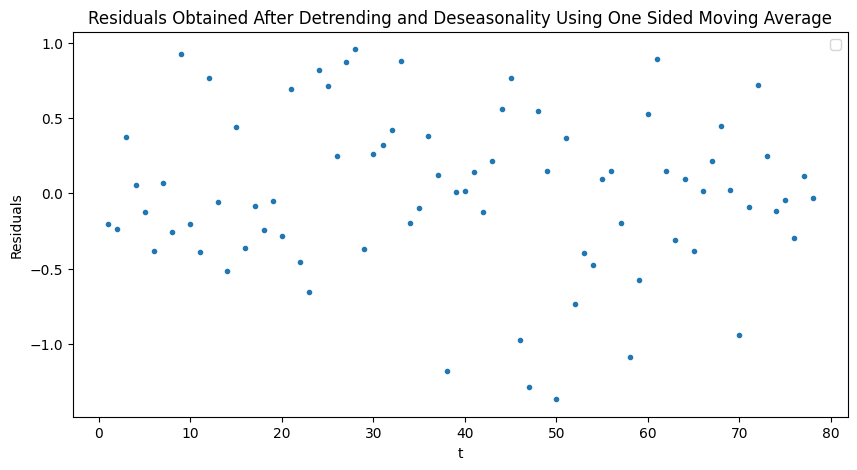

In [682]:
plt.figure(figsize=(10, 5))
plt.plot(train_data_detrend_ma['t'], train_data_detrend_ma['Residual using one sided moving average'], '.')
plt.title('Residuals Obtained After Detrending and Deseasonality Using One Sided Moving Average')
plt.xlabel('t')
plt.ylabel('Residuals')
plt.legend()
plt.show()

### ADF Test to Evaluate the Stationarity of the Data

In [683]:
adf_test(train_data_detrend_ma['Residual using one sided moving average'])

Observations from Dickey-fuller test
Test Statistic                 -1.587374
p-value                         0.489933
#lags used                     11.000000
number of observations used    66.000000
critical value (1%)            -3.533560
critical value (5%)            -2.906444
critical value (10%)           -2.590724
dtype: float64


From the result of ADF test, we can see that the residual series is now more strongly stationary (test statistic of -10.65 as compared to -3.68 obtained using linear regression for detrending). 

### Fitting the ARMA Model

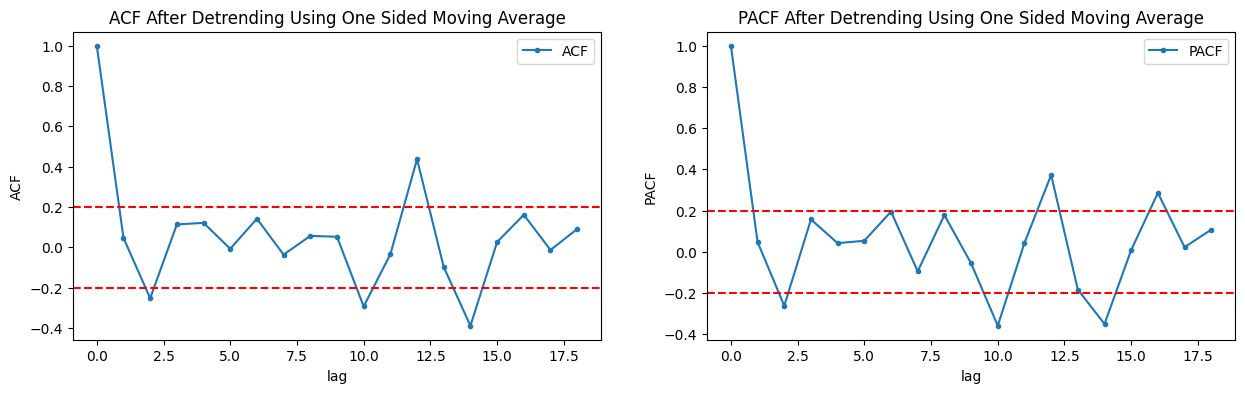

In [684]:
threshold = 0.2
ACF = acf(train_data_detrend_ma['Residual using one sided moving average'].dropna())
PACF = pacf(train_data_detrend_ma['Residual using one sided moving average'].dropna())

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(ACF,'.-',label='ACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF After Detrending Using One Sided Moving Average')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(PACF,'.-',label='PACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.title('PACF After Detrending Using One Sided Moving Average')
plt.legend()

### Training the Model

According to the ACF and PACF plot, we used the ARMA(0,0).

In [685]:
arima_model_0_0 = ARIMA(train_data_detrend_ma['Residual using one sided moving average'].dropna(), order=(2,0,2))
model_0_0 = arima_model_0_0.fit()

/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### In-sample Predictions

/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


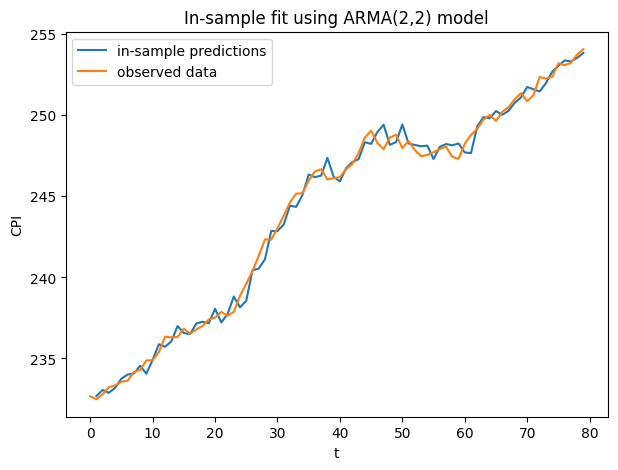

In [686]:
predictions = model_0_0.predict(start = 0, end = len(train_data_detrend_ma)+1) + pd.Series([seasonality[t % 52] for t in train_data_detrend_ma['t']], index = train_data_detrend_ma.index) + train_data_detrend_ma['CPI'] - train_data_detrend_ma['Detrended using one sided moving average']
plt.figure(figsize=(7,5))
plt.plot(predictions, label='in-sample predictions')
plt.plot(train_data_df['CPI'], label='observed data')
plt.xlabel('t')
plt.ylabel('CPI')
plt.title('In-sample fit using ARMA(2,2) model')
plt.legend()

In [687]:
# Insample
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(CPI_df['CPI'][1:80], predictions.dropna()))
mae = mean_absolute_error(CPI_df['CPI'][1:80], predictions.dropna())
mse = mean_squared_error(CPI_df['CPI'][1:80], predictions.dropna())

print(f"In-sample (One Sided Moving Average) RMSE: {rmse}")
print(f"In-sample (One Sided Moving Average) MAE: {mae}")
print(f"In-sample (One Sided Moving Average) MSE: {mse}")

In-sample (One Sided Moving Average) RMSE: 0.5568606574465415
In-sample (One Sided Moving Average) MAE: 0.4390486004727122
In-sample (One Sided Moving Average) MSE: 0.31009379181179436


### Forecasting Out-of-sample Data

In [688]:
test_data_detrend_ma= test_data_df.iloc[1: , :]
test_data_detrend_ma['Detrended using one sided moving average']= detrend(test_data_df['CPI'].values,1)
test_data_detrend_ma

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/2248589772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_detrend_ma['Detrended using one sided moving average']= detrend(test_data_df['CPI'].values,1)


,CPI,t,Detrended using one sided moving average
81,254.358,81,-0.035
82,254.379,82,0.021
83,255.210,83,0.831
84,256.417,84,1.207
85,257.222,85,0.805
86,257.724,86,0.502
87,257.708,87,-0.016
88,258.110,88,0.402
89,258.064,89,-0.046
90,258.274,90,0.210


/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


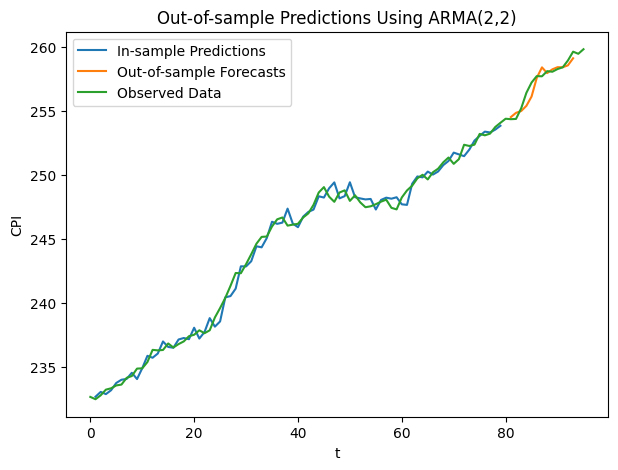

In [689]:
forecasts = model_0_0.forecast(steps = len(test_data_df)) + pd.Series([seasonality[t % 52] for t in test_data_df['t']], index = test_data_df.index) + test_data_df['CPI'] - test_data_detrend_ma['Detrended using one sided moving average']

mean_val = forecasts.mean()

# Calculate deviations from the mean
deviations = forecasts - mean_val

# Amplify the deviations
factor = 1  # Change this factor to adjust the amplification
amplified_deviations = deviations * factor

# Add the mean back to get the amplified series
amplified_series = amplified_deviations + mean_val

shifted_series = amplified_series.shift(0)

plt.figure(figsize=(7,5))
plt.plot(predictions, label='In-sample Predictions')
plt.plot(shifted_series, label='Out-of-sample Forecasts')
plt.plot(CPI_df['CPI'], label='Observed Data')
plt.xlabel('t')
plt.ylabel('CPI')
plt.title('Out-of-sample Predictions Using ARMA(2,2)')
plt.legend()

In [690]:
predictions_onesided = predictions
forecasts_onesided = shifted_series

In [691]:

# Outsample
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(CPI_df['CPI'][81:94], shifted_series.dropna()))
mae = mean_absolute_error(CPI_df['CPI'][81:94], shifted_series.dropna())
mse = mean_squared_error(CPI_df['CPI'][81:94], shifted_series.dropna())

print(f"Out sample (One Sided Moving Average) RMSE: {rmse}")
print(f"Out sample (One Sided Moving Average) MAE: {mae}")
print(f"Out sample (One Sided Moving Average) MSE: {mse}")

Out sample (One Sided Moving Average) RMSE: 0.5203987616230225
Out sample (One Sided Moving Average) MAE: 0.39863589769655267
Out sample (One Sided Moving Average) MSE: 0.27081487109877533


ARMA(0,0) gives better improved predictions as compared to ARMA(1,1).

## Detrending with Right Sided Moving Average

### Detrending

In [692]:
train_data_detrend_rs_ma= train_data_df.iloc[:,:]
window_size = 3

# Calculate the right-sided moving average
rolling_avg = train_data_detrend_rs_ma['CPI'].rolling(window_size).mean().shift(-window_size+1)

# Detrend the time series
detrended = train_data_detrend_rs_ma['CPI'] - rolling_avg

print(detrended)

0     0.018000
1    -0.351333
2    -0.329667
3    -0.144667
4    -0.171667
        ...   
75    0.029667
76   -0.260333
77   -0.453667
78         NaN
79         NaN
Name: CPI, Length: 80, dtype: float64


In [693]:
train_data_detrend_rs_ma['Detrended using right sided moving average'] = detrended
train_data_detrend_rs_ma = train_data_detrend_rs_ma.dropna()
train_data_detrend_rs_ma

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/4136662819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_detrend_rs_ma['Detrended using right sided moving average'] = detrended


,CPI,t,Detrend,Residual,Detrended using right sided moving average
0,232.666,0,-0.697265,-0.909164,0.018000
1,232.486,1,-1.149586,-1.272164,-0.351333
2,232.792,2,-1.115906,-0.987307,-0.329667
3,233.234,3,-0.946227,-1.090164,-0.144667
4,233.339,4,-1.113548,-1.053164,-0.171667
...,...,...,...,...,...
73,252.266,73,-0.976685,-1.099264,-0.349000
74,252.370,74,-1.145006,-1.016407,-0.522333
75,253.209,75,-0.578327,-0.722264,0.029667
76,253.098,76,-0.961648,-0.901264,-0.260333


### Deseasonality

In [694]:
seasonality = seasonal_mean(train_data_detrend_rs_ma['Detrended using right sided moving average'])

### Residuals Obtained after Detrending and Deseaonality

In [695]:
seasonal_train_rs_ma = [ seasonality[i % 52] for i in range(len(train_data_detrend_rs_ma)) ]
train_data_detrend_rs_ma['Residual using right sided moving average'] = train_data_detrend_rs_ma['Detrended using right sided moving average'] - pd.Series(seasonal_train_rs_ma)

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/423323979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_detrend_rs_ma['Residual using right sided moving average'] = train_data_detrend_rs_ma['Detrended using right sided moving average'] - pd.Series(seasonal_train_rs_ma)


### Trend Using Right Sided Moving Average

In [696]:
train_data_detrend_rs_ma['Trend using right sided moving average']= train_data_detrend_rs_ma['CPI'] - train_data_detrend_rs_ma['Detrended using right sided moving average']
train_data_detrend_rs_ma

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/1549917276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_detrend_rs_ma['Trend using right sided moving average']= train_data_detrend_rs_ma['CPI'] - train_data_detrend_rs_ma['Detrended using right sided moving average']


,CPI,t,Detrend,Residual,Detrended using right sided moving average,Residual using right sided moving average,Trend using right sided moving average
0,232.666,0,-0.697265,-0.909164,0.018000,0.147048,232.648000
1,232.486,1,-1.149586,-1.272164,-0.351333,-0.155619,232.837333
2,232.792,2,-1.115906,-0.987307,-0.329667,0.056238,233.121667
3,233.234,3,-0.946227,-1.090164,-0.144667,-0.082333,233.378667
4,233.339,4,-1.113548,-1.053164,-0.171667,-0.020762,233.510667
...,...,...,...,...,...,...,...
73,252.266,73,-0.976685,-1.099264,-0.349000,-0.503333,252.615000
74,252.370,74,-1.145006,-1.016407,-0.522333,-0.078333,252.892333
75,253.209,75,-0.578327,-0.722264,0.029667,0.699278,253.179333
76,253.098,76,-0.961648,-0.901264,-0.260333,-0.131286,253.358333


In [697]:
train_data_detrend_rs_ma['Trend plus seasonality']= train_data_detrend_rs_ma['Trend using right sided moving average'] + pd.Series(seasonal_train_rs_ma)
train_data_detrend_rs_ma['Trend plus seasonality']

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/2970831992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_detrend_rs_ma['Trend plus seasonality']= train_data_detrend_rs_ma['Trend using right sided moving average'] + pd.Series(seasonal_train_rs_ma)


0     232.518952
1     232.641619
2     232.735762
3     233.316333
4     233.359762
         ...    
73    252.769333
74    252.448333
75    252.509722
76    253.229286
77    253.488952
Name: Trend plus seasonality, Length: 78, dtype: float64

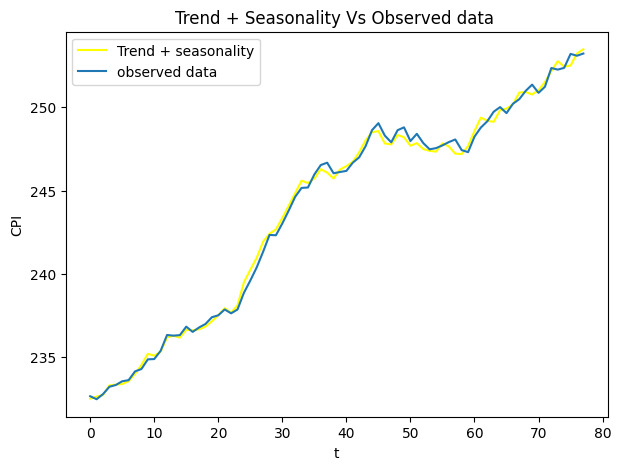

In [698]:
plt.figure(figsize=(7, 5))
plt.plot(train_data_detrend_rs_ma[['t']], train_data_detrend_rs_ma['Trend plus seasonality'], label='Trend + seasonality', color = "yellow")
plt.plot(train_data_detrend_rs_ma['CPI'],label='observed data')
plt.xlabel('t')
plt.ylabel('CPI')
plt.title('Trend + Seasonality Vs Observed data ')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


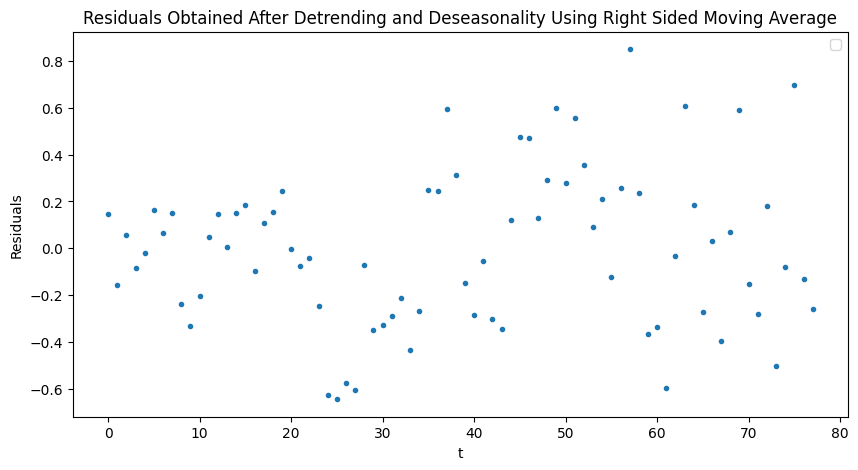

In [699]:
plt.figure(figsize=(10, 5))
plt.plot(train_data_detrend_rs_ma['t'], train_data_detrend_rs_ma['Residual using right sided moving average'], '.')
plt.title('Residuals Obtained After Detrending and Deseasonality Using Right Sided Moving Average')
plt.xlabel('t')
plt.ylabel('Residuals')
plt.legend()
plt.show()

### ADF Test to Evaluate the Stationarity of the Data

In [700]:
adf_test(train_data_detrend_rs_ma['Residual using right sided moving average'])

Observations from Dickey-fuller test
Test Statistic                 -2.491356
p-value                         0.117592
#lags used                      6.000000
number of observations used    71.000000
critical value (1%)            -3.526005
critical value (5%)            -2.903200
critical value (10%)           -2.588995
dtype: float64


### Fitting the ARMA Model

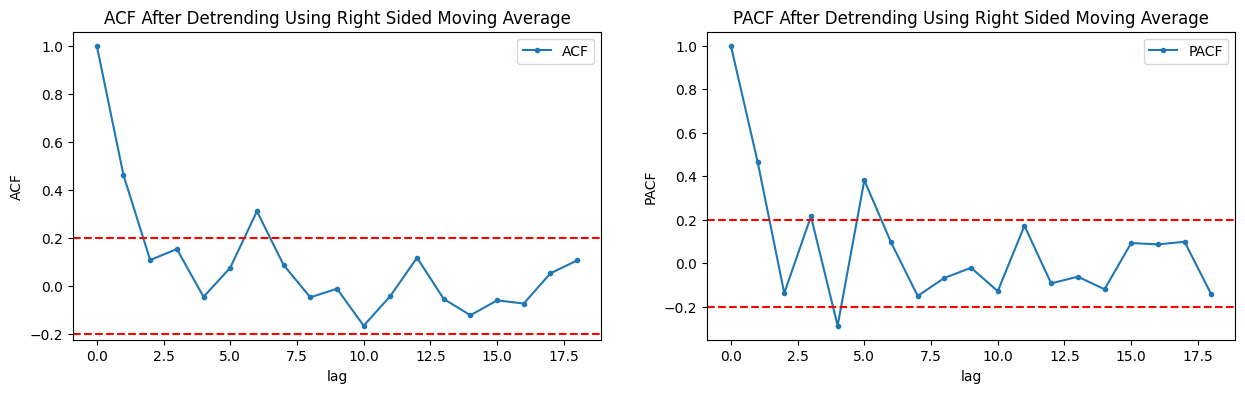

In [701]:
threshold = 0.2
ACF = acf(train_data_detrend_rs_ma['Residual using right sided moving average'].dropna())
PACF = pacf(train_data_detrend_rs_ma['Residual using right sided moving average'].dropna())

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.plot(ACF,'.-',label='ACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF After Detrending Using Right Sided Moving Average')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(PACF,'.-',label='PACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.title('PACF After Detrending Using Right Sided Moving Average')
plt.legend()

### Training the Model

According to the ACF and PACF plot, we used the ARMA(1,1) model.

In [702]:
arima_model_1_1 = ARIMA(train_data_detrend_rs_ma['Residual using right sided moving average'].dropna(), order=(1,0,1))
model_1_1 = arima_model_1_1.fit()

### In-sample Predictions

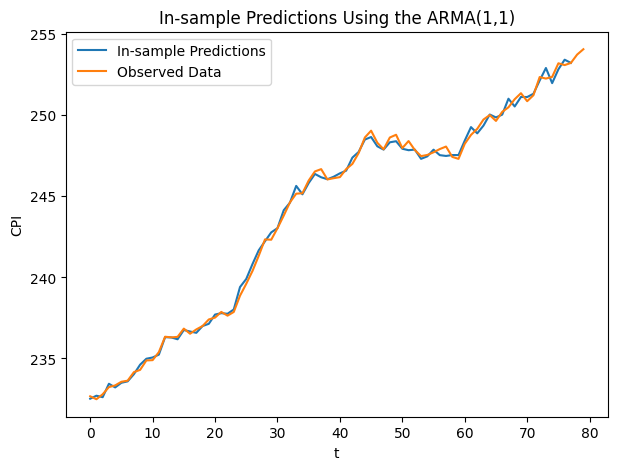

In [703]:
predictions = model_1_1.predict(start = 0, end = len(train_data_detrend_rs_ma)+1) + pd.Series([seasonality[t % 52] for t in train_data_detrend_rs_ma['t']], index = train_data_detrend_rs_ma.index) + train_data_detrend_rs_ma['CPI'] - train_data_detrend_rs_ma['Detrended using right sided moving average']
plt.figure(figsize=(7,5))
plt.plot(predictions, label='In-sample Predictions')
plt.plot(train_data_df['CPI'], label='Observed Data')
plt.xlabel('t')
plt.ylabel('CPI')
plt.title('In-sample Predictions Using the ARMA(1,1)')
plt.legend()

### Forecasting Out-of-sample Data

In [704]:
test_data_detrend_rs_ma= test_data_df.iloc[:,:]
window_size = 3

# Calculate the right-sided moving average
rolling_avg = test_data_detrend_rs_ma['CPI'].rolling(window_size).mean().shift(-window_size+1)

# Detrend the time series
detrended = test_data_detrend_rs_ma['CPI'] - rolling_avg

print(detrended)

80    0.016333
81   -0.291000
82   -0.956333
83   -1.073000
84   -0.704000
85   -0.329333
86   -0.123333
87   -0.252667
88   -0.039333
89   -0.185333
90   -0.268333
91   -0.585000
92   -0.404333
93   -0.008667
94         NaN
95         NaN
Name: CPI, dtype: float64


In [705]:
test_data_detrend_rs_ma['Detrended using right sided moving average']= detrended.dropna()
test_data_detrend_rs_ma

/var/folders/_s/49hfhkwd75n_f9vl_c9csh680000gn/T/ipykernel_25005/3792725414.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_detrend_rs_ma['Detrended using right sided moving average']= detrended.dropna()


,CPI,t,Detrended using right sided moving average
80,254.393,80,0.016333
81,254.358,81,-0.291000
82,254.379,82,-0.956333
83,255.210,83,-1.073000
84,256.417,84,-0.704000
85,257.222,85,-0.329333
86,257.724,86,-0.123333
87,257.708,87,-0.252667
88,258.110,88,-0.039333
89,258.064,89,-0.185333


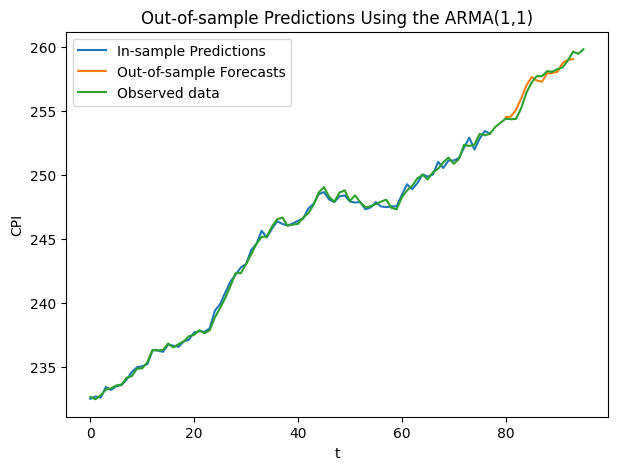

In [706]:
forecasts_rs_ma = model_1_1.forecast(steps = len(test_data_df)) + pd.Series([seasonality[t % 52] for t in test_data_df['t']], index = test_data_df.index) + test_data_df['CPI'] - test_data_detrend_rs_ma['Detrended using right sided moving average']

mean_val = forecasts_rs_ma.mean()

# Calculate deviations from the mean
deviations = forecasts_rs_ma - mean_val

# Amplify the deviations
factor =0.9  # Change this factor to adjust the amplification
amplified_deviations = deviations * factor

# Add the mean back to get the amplified series
amplified_series = amplified_deviations + mean_val

shifted_series = amplified_series.shift(0)

plt.figure(figsize=(7,5))
plt.plot(predictions, label='In-sample Predictions')
plt.plot(shifted_series, label='Out-of-sample Forecasts')
plt.plot(CPI_df['CPI'], label='Observed data')
plt.xlabel('t')
plt.ylabel('CPI')
plt.title('Out-of-sample Predictions Using the ARMA(1,1)')
plt.legend()

In [707]:
predictions_rightsided = predictions
forecasts_rightsided = shifted_series

In [708]:
# Insample
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(CPI_df['CPI'][:78], predictions[:78]))
mae = mean_absolute_error(CPI_df['CPI'][:78], predictions[:78])
mse = mean_squared_error(CPI_df['CPI'][:78], predictions[:78])

print(f"In-sample (Right Sided Moving Average) RMSE: {rmse}")
print(f"In-sample (Right Sided Moving Average) MAE: {mae}")
print(f"In-sample (Right Sided Moving Average) MSE: {mse}")

In-sample (Right Sided Moving Average) RMSE: 0.27220844360932267
In-sample (Right Sided Moving Average) MAE: 0.21908948620318677
In-sample (Right Sided Moving Average) MSE: 0.07409743677220978


In [709]:
# Outsample
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(CPI_df['CPI'][80:94], shifted_series.dropna()))
mae = mean_absolute_error(CPI_df['CPI'][80:94], shifted_series.dropna())
mse = mean_squared_error(CPI_df['CPI'][80:94], shifted_series.dropna())

print(f"Out sample (Right Sided Moving Average) RMSE: {rmse}")
print(f"Out sample (Right Sided Moving Average) MAE: {mae}")
print(f"Out sample (Right Sided Moving Average) MSE: {mse}")

Out sample (Right Sided Moving Average) RMSE: 0.4245383767285162
Out sample (Right Sided Moving Average) MAE: 0.3610806693409095
Out sample (Right Sided Moving Average) MSE: 0.18023283331528353


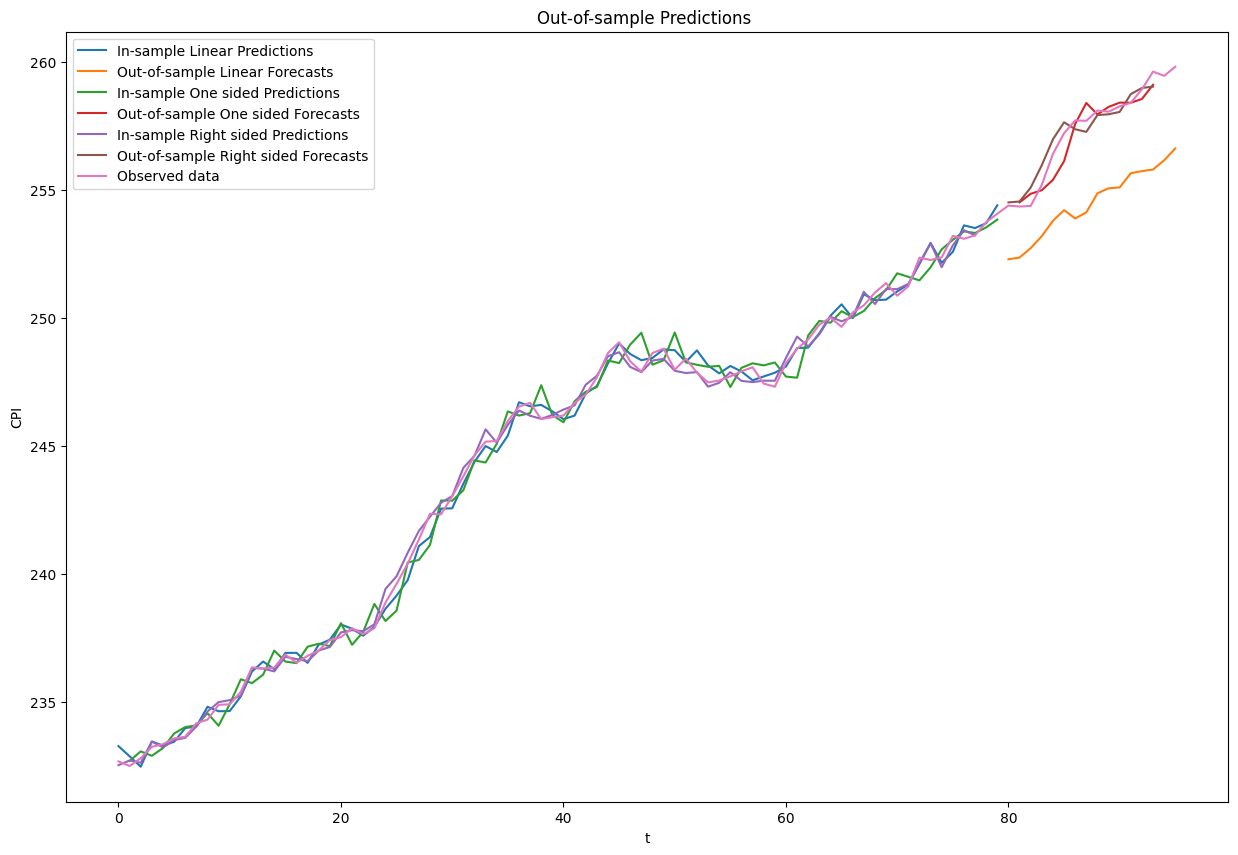

In [710]:
plt.figure(figsize=(15,10))

plt.plot(predictions_linear, label='In-sample Linear Predictions')
plt.plot(forecasts_linear, label='Out-of-sample Linear Forecasts')

plt.plot(predictions_onesided, label='In-sample One sided Predictions')
plt.plot(forecasts_onesided, label='Out-of-sample One sided Forecasts')

plt.plot(predictions_rightsided, label='In-sample Right sided Predictions')
plt.plot(forecasts_rightsided, label='Out-of-sample Right sided Forecasts')

plt.plot(CPI_df['CPI'], label='Observed data')
plt.xlabel('t')
plt.ylabel('CPI')
plt.title('Out-of-sample Predictions ')
plt.legend()

As the results of three different ways of detrended data, the forecasts obtained by detrending using right sided moving average are better than that obtained using one sided moving average or linear regression.

In [711]:
print('Done!')

Done!
